# export this to other file formats

These files are symbolically linked such that their source is the
version-controlled directory, but they can be exported from the local
directory where the analysis happens

Due to this difference in directory structure, anyone else using these
scripts will have to make sure the locations of their data are specified
correctly in the [set working
directories](id:e048d701-1479-46eb-8953-498df23e3401) section.

## convert to jupyter notebook

### using pandoc

this looks nice but it's just a big markdown block

``` bash
pandoc 6.11.6_analysis.org -o gliding_analysis_pandoc.ipynb
```

### using orgparse

this is the only way that makes runnable python cells, though lots of
formatting doesn't work

``` python
import orgparse
import nbformat as nbf
import re
import base64

def parse_results(results_block):
    """
    Parse the #+RESULTS: block to extract outputs.
    """
    outputs = []
    lines = results_block.strip().split("\n")

    for line in lines:
        if line.strip().startswith(": "):
            outputs.append(nbf.v4.new_output(output_type="stream", name="stdout", text=line[2:].strip() + "\n"))
        elif re.match(r"\[\[.*\.(png|jpg|jpeg|gif)\]\]", line.strip()):
            image_path = re.search(r"\[\[(.*\.(png|jpg|jpeg|gif))\]\]", line.strip()).group(1)
            try:
                with open(image_path, "rb") as f:
                    image_data = base64.b64encode(f.read()).decode("utf-8")
                outputs.append(nbf.v4.new_output(
                    output_type="display_data",
                    data={"image/png": image_data},
                    metadata={}
                ))
            except FileNotFoundError:
                print(f"Warning: Image file not found: {image_path}")
    return outputs

def convert_org_links_to_markdown(text):
    """
    Convert Org mode links to Markdown links.
    """
    text = re.sub(r"\[\[([^\]]+)\]\[([^\]]+)\]\]", r"[\2](\1)", text)
    text = re.sub(r"\[\[([^\]]+)\]\]", r"[\1](\1)", text)
    return text

def org_to_ipynb(org_file, ipynb_file):
    org = orgparse.load(org_file)
    nb = nbf.v4.new_notebook()
    cells = []

    for node in org[1:]:
        if ":noexport:" in node.tags or (node.heading and ":noexport:" in node.heading.lower()):
            continue

        if node.heading:
            heading_level = "#" * node.level
            cells.append(nbf.v4.new_markdown_cell(f"{heading_level} {node.heading}"))

        in_code_block = False
        in_results_block = False
        code_lines = []
        markdown_lines = []
        results_block = ""

        for line in node.body.split("\n"):
            if line.strip().startswith("#+BEGIN_SRC python"):
                in_code_block = True
                if markdown_lines:
                    markdown_text = convert_org_links_to_markdown("\n".join(markdown_lines)).strip()
                    if markdown_text:
                        cells.append(nbf.v4.new_markdown_cell(markdown_text))
                    markdown_lines = []
                continue
            elif line.strip().startswith("#+END_SRC"):
                in_code_block = False
                if code_lines:
                    code_cell = nbf.v4.new_code_cell("\n".join(code_lines))
                    cells.append(code_cell)
                    code_lines = []
                continue
            elif line.strip().startswith("#+RESULTS:"):
                in_results_block = True
                continue
            elif in_results_block and line.strip() == ":end:":
                in_results_block = False
                if results_block.strip():
                    outputs = parse_results(results_block)
                    if outputs and cells:
                        cells[-1].outputs = outputs
                results_block = ""
            elif in_code_block:
                code_lines.append(line)
            elif in_results_block:
                results_block += line + "\n"
            else:
                markdown_lines.append(convert_org_links_to_markdown(line))

        markdown_text = convert_org_links_to_markdown("\n".join(markdown_lines)).strip()
        if markdown_text:
            cells.append(nbf.v4.new_markdown_cell(markdown_text))

    nb.cells = cells
    with open(ipynb_file, "w") as f:
        nbf.write(nb, f)

# Convert your Org file
org_to_ipynb("6.11.6_analysis.org",
             "gliding_analysis_orgparse.ipynb")
```

``` commonlisp
(org-babel-tangle)
```

``` bash
python convert_org_to_ipynb.py
```

## export to org document

``` commonlisp
(org-org-export-to-org)
```

## export to markdown document

``` commonlisp
(org-md-export-to-markdown)
```

# figure generation index

| figure | panel | link                                                            |
|--------|-------|-----------------------------------------------------------------|
| S2     | D     | [final myo parameters](id:7c65b913-896c-4575-b326-f24ab1e4ab03) |

# configuration

## set global variables

``` python
#timestep = 5e-5
report = 'no'
replace_movies = 'no'
save_figures = 'yes'
save_dataframes = 'yes'
```

## load and configure libraries

``` python
import os
import sys
from tabulate import tabulate
import math
import numpy as np
import pandas as pd
import shutil
import subprocess
from subprocess import Popen
import datetime
import matplotlib.pyplot as plt  # plotting
import seaborn as sns  # nicer plotting
from decimal import Decimal
import matplotlib.colors as mplcolors
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
from matplotlib.cm import ScalarMappable
from scipy.stats import binned_statistic_2d
from scipy import stats
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
import textwrap
from decimal import Decimal
from scipy.stats import binned_statistic_2d
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt  # plotting
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
plt.style.use('seaborn-v0_8-colorblind') # set plot style
plt.cool()                          # heatmap color scheme
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=mcolors.TABLEAU_COLORS)
%matplotlib inline

import seaborn as sns  # nicer plotting
sns.set_style('whitegrid')  # set plot style

SMALL_SIZE = 20
MEDIUM_SIZE = 24
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=[6,5]) # default figure width, height

now = datetime.datetime.now()
date = now.strftime('%Y%m%d')
pref = date
```

## set working directories

``` python
#machine = 'peeks'
machine = 'ltpbukem'

if machine == 'ltpbukem':
    drive_dir = '/home/maxferrin/google_drive/'

if machine == 'bizon':
    drive_dir = '/media/bizon/DATA/MFerrin/insync/'

if machine == 'peeks':
    drive_dir = '/scratch/ferrin/unison_peeks/'

if machine == 'drumroom':
    drive_dir = '/Users/max/google_drive/'

if machine == 'mbp':
    drive_dir = '/Users/maxferrin/google_drive/'

if machine == 'sobarky':
    drive_dir = '/Users/dblab/google_drive/'


working_dir = os.path.join(drive_dir, 'grad_school/db_lab/code/analysis/6.11.6_temp/')
cytosim_dir = os.path.join(drive_dir, 'grad_school/db_lab/code/cytosim_dblab/', machine)

if machine == 'peeks':
    working_dir = '/run/media/ferrin/Volume/max/analysis/6.11.6_temp/'
    cytosim_dir = '/home/ferrin/cytosim/'

dataframes_dir = os.path.join(working_dir,'dataframes/')

os.chdir(working_dir)

if os.path.isdir('figures') == False:
    os.mkdir('figures')
if os.path.isdir('dataframes') == False:
    os.mkdir('dataframes')
```

## load custom functions

``` python
# add parent folder to path
sys.path.insert(1, '../')
from cytosim_analysis import cytosim_analysis_functions as caf

# reload custom library
from importlib import reload
reload(sys.modules['cytosim_analysis'])
```

# find directories that have outputs or config files

``` python
output_dirs, config_dirs = caf.find_directories()
print(output_dirs, config_dirs)
```

``` example
['6.11.6_output'] ['6.11.6']
```

# report simulations

this crashes

``` python
solid_allruns_allparams, properties_allruns_allparams, \
configs_allruns_allparams, single_hip1r_allruns_allparams, \
single_membrane_myosin_allruns_allparams, fiber_forces_allruns_allparams, \
fiber_clusters_allruns_allparams, fiber_tensions_allruns_allparams, \
fiber_ends_allruns_allparams, rundirs_allparams, total_runs = \
caf.report_sims(working_dir, output_dirs, config_dirs, cytosim_dir,
report, replace_movies)
```

this is better

``` python
 properties_allruns_allparams, configs_allruns_allparams, \
 fiber_ends_allruns_allparams, rundirs_allparams, \
 total_runs = caf.report_fiber_ends(
     working_dir, output_dirs, config_dirs,
     cytosim_dir, report, replace_movies)

rundirs_allparams_df = pd.DataFrame.from_dict(rundirs_allparams, orient = 'index')
if save_dataframes == 'yes':
    rundirs_allparams_df.to_pickle(dataframes_dir+'rundirs_allparams.pkl')
```

``` example
finished reporting 6.11.6_output
```

# read simulation properties

## put all properties and configs into dataframes

``` python
properties_allparams, config_allparams = caf.props_configs(
    output_dirs, rundirs_allparams_df,
    properties_allruns_allparams, configs_allruns_allparams)
```

## filter for properties that vary among simulations

``` python
cols = list(properties_allparams)
nunique = properties_allparams.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
properties_unique = properties_allparams.drop(cols_to_drop, axis=1)
#properties_unique = properties_unique.drop(labels='internalize_random_seed',axis=1)
properties_unique.head()
```

|                                                       |
|-------------------------------------------------------|
| ('6.11.6<sub>output</sub>', 'run0019<sub>0000</sub>') |

``` python
cols = list(config_allparams)
nunique = config_allparams.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
config_unique = config_allparams.drop(cols_to_drop, axis=1)
#config_unique = config_unique.drop(['membrane_myosin_position'], axis=1)
config_unique = config_unique.astype('float')
config_unique.head()
```

|                                                       |
|-------------------------------------------------------|
| ('6.11.6<sub>output</sub>', 'run0019<sub>0000</sub>') |

# parse results into dataframe

## fiber ends

``` python
ends_allparams = caf.get_fiber_ends_2d(output_dirs, rundirs_allparams_df, fiber_ends_allruns_allparams)

if save_dataframes == 'yes':
    ends_allparams.to_pickle(dataframes_dir+'ends_allparams.pkl')

ends_allparams.head()
```

# load in previously parsed dataframes

``` python
ends_allparams = pd.read_pickle(dataframes_dir+'ends_allparams.pkl')
rundirs_allparams_df = pd.read_pickle(dataframes_dir+'rundirs_allparams.pkl')
rundirs_allparams_df.fillna(value='empty', inplace=True)
```

# plot results

## actin plus end displacement

### all parameters

``` python
num_plots = total_runs

width = 6
if width > num_plots:
    width = 1
height = int(math.ceil(float(num_plots)/float(width)))

#max_int = solid_allparams['internalization'].max()*1000

# plt.figure(figsize=(4*width,3*height)) #width, height
fig, ax = plt.subplots(nrows=height, ncols=width, sharex=True, sharey=True, figsize=(6*width,7*height))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
fig.text(0.5, 0, 'time (s)', ha='center', size=24)
fig.text(0, 0.5, 'barbed end displacement (μm)', va='center', rotation='vertical', size=24)

plot_no = 0

for output_dir in output_dirs:
    rundirs = rundirs_allparams[output_dir]
    for run in rundirs:

        props = config_allparams.loc[output_dir].loc[run]
        #viscosity = props['internalize.cym_viscosity']
        #hip1r_off = props['strongbinder_unbinding'].split(',')[0]

        plot_no += 1

        plt.subplot(height,width,plot_no) #height, width
        for fiber_id in range(1,26):
            xdisp = ends_allparams.loc[[output_dir], [run], :, [fiber_id]]['plus_xpos']-ends_allparams.loc[(output_dir, run, 0.1, fiber_id)]['plus_xpos']
            ydisp = ends_allparams.loc[[output_dir], [run], :, [fiber_id]]['plus_ypos']-ends_allparams.loc[(output_dir, run, 0.1, fiber_id)]['plus_ypos']
            disp = np.sqrt(np.square(xdisp) + np.square(ydisp))
            x = xdisp.reset_index()['time']
            y = disp
            plt.plot(x,y)
        plt.xlim(right = 5)
        plt.ylim(top = 1.5)
        # plt.xlabel('time (s)')
        # plt.ylabel('internalization (nm)')

        title = output_dir+'\n'+run+'\n'
        for prop in list(config_unique):
            title += prop + ' = ' + str(props[prop]) + '\n'

        # for prop, value in zip(config_groups, name):
        #     title += prop + ' = ' + str(value) + '\n'


        plt.title(title)

plt.tight_layout()

if save_figures == 'yes':
  plt.savefig(working_dir+'figures/'+pref+'_plusend_disp-vs-time_all.png')
```

``` example
/tmp/ipykernel_84634/564072330.py:30: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(height,width,plot_no) #height, width
```

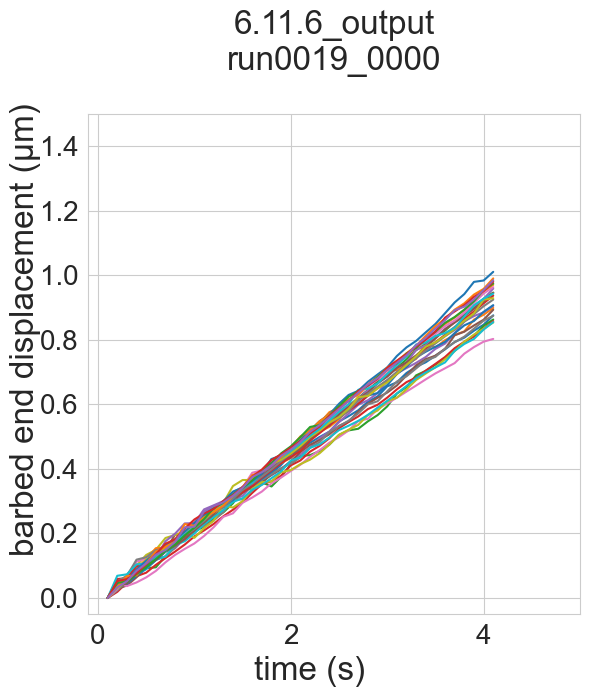

### final myo parameters

``` python
plt.figure(figsize=[6,5])

for fiber_id in range(1,26):
    xdisp = ends_allparams.loc[['6.11.6_output'], ['run0019_0000'], :, [fiber_id]]['plus_xpos']-ends_allparams.loc[('6.11.6_output', 'run0019_0000', 0.1, fiber_id)]['plus_xpos']
    ydisp = ends_allparams.loc[['6.11.6_output'], ['run0019_0000'], :, [fiber_id]]['plus_ypos']-ends_allparams.loc[('6.11.6_output', 'run0019_0000', 0.1, fiber_id)]['plus_ypos']
    disp = np.sqrt(np.square(xdisp) + np.square(ydisp))
    x = xdisp.reset_index()['time']
    y = disp
    plt.plot(x,y)

plt.xlabel('Time ($s$)')
plt.ylabel('Barbed end\ndisplacement ($\mu m$)')
plt.tight_layout()

if save_figures == 'yes':
    plt.savefig(working_dir+'figures/publish/gliding_displacement.svg')
```

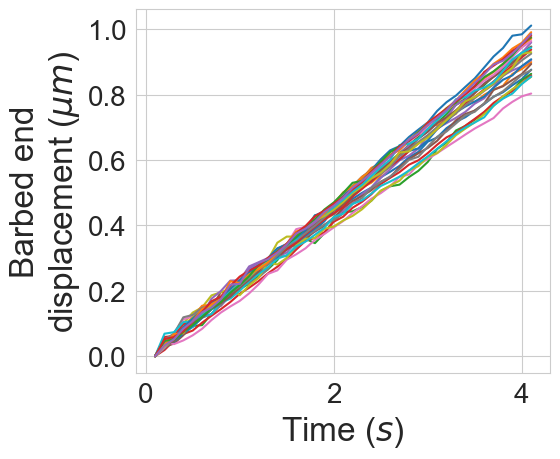

``` python
config_allparams.loc[('6.11.6_output', 'run0019_0000')]
```